In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

TAREA 1: Realiza la cuenta de píxeles blancos por filas (en lugar de por columnas). 
Determina el valor máximo de píxeles blancos para filas, maxfil, mostrando el número de filas y sus respectivas posiciones, con un número de píxeles blancos mayor  o igual que 0.90*maxfil.

Max píxeles blancos por fila: 0.4296875
Filas con >=90 %d el máximo: [  6  12  15  20  21  88 100]


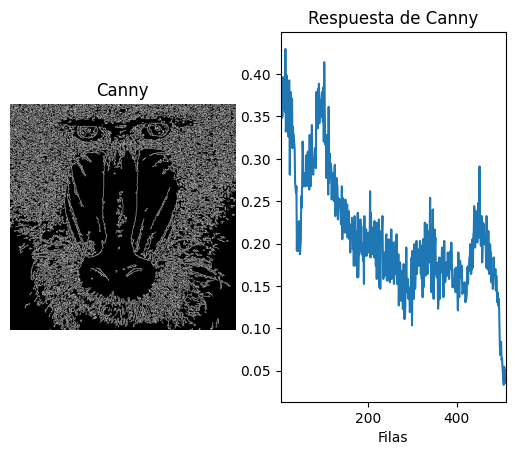

In [3]:
# Carga la imagen desde el archivo
img = cv2.imread('/Users/mttrizza/Desktop/mandril.jpg')

# Conversión de la imagen original en BGR a niveles de grises
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Obtención de bordes con el operador de Canny
# Parámetros: imagen de entrada, umbral inferior y umbral superior
canny = cv2.Canny(gris, 100, 200)

# El contenido de la imagen resultado de Canny son valores 0 (negro) o 255 (blanco)
# Aquí contamos el número de píxeles blancos (255) por fila
# Se hace una reducción sumando los valores de cada fila
row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

# Normalizamos el resultado dividiendo entre:
#  - 255 (valor máximo del píxel blanco)
#  - número de columnas de la imagen (canny.shape[1])
# Así obtenemos el número relativo de píxeles blancos por fila
rows = row_counts[:,0] / (255 * canny.shape[1])

# Determinamos el valor máximo de píxeles blancos por fila
maxfil = rows.max()

# Identificamos las filas que tienen al menos el 90% del máximo
filas_significativas = np.where(rows >= 0.9 * maxfil)[0]

# Mostramos por consola los resultados
print("Max píxeles blancos por fila:", maxfil)
print("Filas con >=90 %d el máximo:", filas_significativas)

# Representación gráfica de los resultados
plt.figure()

# Primera subfigura: mostramos el resultado de Canny
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Canny")
plt.imshow(canny, cmap='gray') 

# Segunda subfigura: mostramos la cantidad de píxeles blancos por fila
plt.subplot(1, 2, 2)
plt.title("Respuesta de Canny")
plt.xlabel("Filas")
plt.ylabel("% píxeles")
plt.plot(rows)

# Definimos el rango del eje x en base al número de filas
plt.xlim([1, canny.shape[0]])

plt.show()

TAREA 2: Aplica umbralizado a la imagen resultante de Sobel (convertida a 8 bits), y posteriormente realiza el conteo por filas y columnas similar al realizado en el ejemplo con la salida de Canny de píxeles no nulos. Calcula el valor máximo de la cuenta por filas y columnas, y determina las filas y columnas por encima del 0.90*máximo. Remarca con alguna primitiva gráfica dichas filas y columnas sobre la imagen del mandril. ¿Cómo se comparan los resultados obtenidos a partir de Sobel y Canny?

In [ ]:
# parametros
GAUSS_K = 3 # Tamaño del kernel Gaussiano (debe ser impar) para el filtro de desenfoque
CANNY_T1, CANNY_T2 = 100, 200 # Umbrales inferior y superior para el detector de bordes de Canny

g = cv2.GaussianBlur(gray, (GAUSS_K, GAUSS_K), 0) # Applica una sfocatura gaussiana per ridurre il rumore e ammorbidire i dettagli# === CARGA ===
bgr = cv2.imread('/Users/mttrizza/Desktop/mandril.jpg') # Carga la imagen desde archivo en formato BGR (por defecto de OpenCV)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB) # Convierte la imagen a formato RGB (útil para matplotlib)
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY) # Convierte la imagen a escala de grises (necesaria para Sobel y Canny)

# gradiente y magnitud
sx = cv2.Sobel(g, cv2.CV_64F, 1, 0, ksize=3) # Calcula el gradiente horizontal (derivada respecto a x)
sy = cv2.Sobel(g, cv2.CV_64F, 0, 1, ksize=3) # Calcula el gradiente vertical (derivada respecto a y)

# aquí obtienes la verdadera información física sobre la intensidad del borde en cada punto
mag = np.hypot(sx, sy) # Calcula la magnitud del gradiente (sqrt(sx^2 + sy^2)), np.hypot --> calcula el módulo píxel por píxel

# imagen de visualización / post-procesamiento, comprimida en 0–255, apta para funciones como threshold o para mostrar el borde en pantalla
mag8 = cv2.convertScaleAbs(mag) # Convierte la magnitud a imagen de 8 bits para poder visualizarla

# THRESHOLD (umbralizado) sobre SOBEL (Otsu), sirve para binarizar la imagen mag8, es decir, transformarla en blanco/negro (0 o 255) para aislar los bordes.
_, sobel_bin = cv2.threshold( # Aplica un threshold para obtener una imagen binaria
    mag8, # imagen que usamos
      0, 255, # de.. a..
        cv2.THRESH_BINARY + cv2.THRESH_OTSU # Usa el método de Otsu para elegir automáticamente el umbral
)

# Cannycanny = cv2.Canny(g, CANNY_T1, CANNY_T2) # Aplica el algoritmo de Canny para la detección de bordes

# FUNCIONES DE CONTEO

# por “bordes” aquí entendemos: los píxeles que el algoritmo Sobel (después del umbral)
# o Canny ha reconocido como puntos donde la imagen cambia de intensidad
# de forma notable

def counts_rows_cols(binary_img):
    # Cuenta los píxeles distintos de cero (es decir, los bordes) para cada fila y cada columna
    nz = (binary_img > 0) # Máscara booleana: True donde el píxel es distinto de 0
    row_counts = nz.sum(axis=1).astype(int) # Suma por fila → número de píxeles “borde” en cada fila
    col_counts = nz.sum(axis=0).astype(int) # Suma por columna → número de píxeles “borde” en cada columna
    return row_counts, col_counts # Devuelve dos vectores: conteo por filas y por columnas

def max_and_indices_ge(counts, alpha=0.90):
    # counts: array que contiene para cada fila y columna el número de píxeles de borde
    # alpha: factor para fijar un umbral relativo al máximo

    # Encuentra el máximo de los conteos y las posiciones donde el conteo es ≥ (alpha * máximo)
    m = int(counts.max()) # Valor máximo entre counts
    thr = int(np.ceil(alpha * m)) # Umbral = alpha * máximo (redondeado hacia arriba)
    # .ceil redondea hacia arriba

    idx = np.flatnonzero(counts >= thr) # Índices (filas o columnas) que superan el umbral
    # .flatnonzero devuelve los índices donde es TRUE
    return m, thr, idx # Devuelve: máximo, umbral, índices significativos

# Conteossobel_rows, sobel_cols = counts_rows_cols(sobel_bin) # Cuenta los píxeles de borde por filas/columnas a partir de la imagen Sobel binaria
canny_rows, canny_cols = counts_rows_cols(canny) # Cuenta los píxeles de borde por filas/columnas a partir de la imagen Canny

# Calcula máximos e índices para Sobel
sobel_r_max, sobel_r_thr, sobel_r_idx = max_and_indices_ge(sobel_rows, 0.90)
sobel_c_max, sobel_c_thr, sobel_c_idx = max_and_indices_ge(sobel_cols, 0.90)

# Calcula máximos e índices para Canny
canny_r_max, canny_r_thr, canny_r_idx = max_and_indices_ge(canny_rows, 0.90)
canny_c_max, canny_c_thr, canny_c_idx = max_and_indices_ge(canny_cols, 0.90)

# Dibuja líneas horizontales (rojas) sobre las filas con conteo alto
# y líneas verticales (verdes) sobre las columnas con conteo alto.
def overlay_lines(img_rgb, # entrada
                  rows_idx, cols_idx, # índices fila y columna
                  color_rows=(255,0,0), color_cols=(0,255,0), # color rojo y verde
                  thickness=1): # grosor

    out = img_rgb.copy() # Copia de la imagen de partida
    h, w = out.shape[:2] # Lee las dimensiones de la imagen

    # Dibuja las filas (horizontales) en rojo
    for r in rows_idx:
        cv2.line(out, (0, r), (w-1, r), # de izquierda a derecha, r es la coordenada Y
                 color_rows, thickness)

    # Dibuja las columnas (verticales) en verde
    for c in cols_idx:
        cv2.line(out, (c, 0), (c, h-1), color_cols, thickness)

    return out # Devuelve la imagen con las líneas superpuestas

sobel_mark = overlay_lines(rgb, sobel_r_idx, sobel_c_idx)  # Aplica overlay de las líneas para Sobel
canny_mark = overlay_lines(rgb, canny_r_idx, canny_c_idx)  # Aplica overlay de las líneas para Canny

# visualicion
plt.figure(figsize=(14,9)) # Crea una ventana gráfica de tamaño adecuado

plt.subplot(2,3,1); plt.title("Original"); plt.axis("off"); plt.imshow(rgb) # Muestra la imagen original
plt.subplot(2,3,2); plt.title("Sobel magnitud (8-bit)"); plt.axis("off"); plt.imshow(mag8, cmap="gray") # Muestra Sobel
plt.subplot(2,3,3); plt.title("Canny"); plt.axis("off"); plt.imshow(canny, cmap="gray") # Muestra Canny

plt.subplot(2,3,4); plt.title("Sobel: filas/col ≥ 0.90·max"); plt.axis("off"); plt.imshow(sobel_mark) # Sobel con líneas
plt.subplot(2,3,5); plt.title("Canny: filas/col ≥ 0.90·max"); plt.axis("off"); plt.imshow(canny_mark) # Canny con líneas

plt.tight_layout() # Optimiza los espacios entre las figuras
plt.show() # Muestra la ventana con las imágenes

# Comparación
def dump_counts(name, r_max, # máximo conteo filas
                 r_thr, # umbral usado para las filas
                 r_idx, # índices de las filas con conteo >= umbral
                 c_max, c_thr, c_idx):
    # Imprime un resumen de los conteos por filas y columnas
    print(f"\n== {name} ==")
    print(f"Filas: max={r_max}, umbral={r_thr} (≥ 0.90·max), n_filas={len(r_idx)}") # Info sobre las filas
    print(f"  Índices filas (primeros 20): {r_idx[:20]}") # Muestra los primeros 20 índices de filas
    print(f"Columnas: max={c_max}, umbral={c_thr} (≥ 0.90·max), n_columnas={len(c_idx)}") # Info sobre las columnas
    print(f"  Índices columnas (primeros 20): {c_idx[:20]}") # Muestra los primeros 20 índices de columnas

# Imprime las estadísticas para Sobel y para Canny
dump_counts("SOBEL", sobel_r_max, sobel_r_thr, sobel_r_idx, sobel_c_max, sobel_c_thr, sobel_c_idx)
dump_counts("CANNY", canny_r_max, canny_r_thr, canny_r_idx, canny_c_max, canny_c_thr, canny_c_idx)


TAREA 3: Proponer un demostrador que capture las imágenes de la cámara, y les permita exhibir lo aprendido en estas dos prácticas ante quienes no cursen la asignatura :). Es por ello que además de poder mostrar la imagen original de la webcam, permita cambiar de modo, incluyendo al menos dos procesamientos diferentes como resultado de aplicar las funciones de OpenCV trabajadas hasta ahora.

In [ ]:
vid = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)            

mode = 0 # Modo de filtro inicial: 0=Original, 1=Gris, 2=Pop-art, 3=Canny, 4=Threshold
window = "Webcam - Filtros (0-4, q para salir)" # Nombre de la ventana donde mostramos el video


cv2.namedWindow(window, cv2.WINDOW_NORMAL) # Crea la ventana y permite al usuario redimensionarla

try:
    while True:                                  
        ok, frame = vid.read() # Lee un fotograma de la webcam (ok=True si la lectura tuvo éxito)                 

        if mode == 0: # Modo 0: imagen original (sin filtro)
            img, nome = frame, "Original" # img = fotograma original; nome = nombre del filtro para el texto superpuesto

        elif mode == 1: # Modo 1: escala de grises
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Convierte BGR -> Gris (1 canal)
            img  = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR) # Vuelve a BGR para poder escribir texto en color encima
            nome = "Escala de grises" 

        elif mode == 2: # Modo 2: efecto "Pop-art"
            b, g, r = cv2.split(frame)          
            bl = frame.copy() # Crea una copia del fotograma a modificar
            bl[:, :, 0] = b                      
            bl[:, :, 1] = 255 - r             
            bl[:, :, 2] = 120 - g                
            img, nome = bl, "Pop-art"        

        elif mode == 3: # Modo 3: Canny (detección de bordes)
            edges = cv2.Canny(frame, 100, 200) # Aplica Canny (salida en escala de grises: 0 o 255)
            img  = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR) # Convierte a BGR para poder escribir texto
            nome = "Canny"                    

        elif mode == 4: # Modo 4: Threshold (umbral binario)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Primero convierte a gris
            _, th = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY) # Aplica umbral 120 -> 0/255
            img  = cv2.cvtColor(th, cv2.COLOR_GRAY2BGR) # Vuelve a BGR para el texto superpuesto
            nome = "Threshold"           

        else: # Cualquier otro valor inesperado -> vuelve a original
            img, nome = frame, "Original" # Valor por defecto seguro

        testo = f"Filtro: {nome}  |  0:Orig 1:Gris 2:Pop 3:Canny 4:Thresh  q/ESC:Salir"  # Cadena de guía
        cv2.putText( # Dibuja el texto en la parte superior izquierda
            img, # Imagen sobre la que escribir
            testo, # Texto a escribir
            (12, 28), # Posición (x, y) en píxeles
            cv2.FONT_HERSHEY_SIMPLEX, # Fuente
            0.7, # Escala de la fuente
            (255, 255, 255), # Color del texto (blanco)
            2, # Grosor del texto
            cv2.LINE_AA # Antialiasing para líneas más suaves
        )

        cv2.imshow(window, img) # Muestra el fotograma (con filtro y texto) en la ventana


        if cv2.getWindowProperty(window, cv2.WND_PROP_VISIBLE) < 1:  # Si la ventana ya no es visible...
            break # ...sal del bucle de manera limpia

        key = cv2.waitKey(1) & 0xFF # Lee el código de la tecla presionada (8 bits)
        if key in (ord('q'), ord('Q'), 27): # Si 'q' o 'Q' o ESC (27) -> salir
            break
        elif key in (ord('0'), ord('1'), ord('2'), ord('3'), ord('4')): # Si 0..4 -> cambia modo
            mode = int(chr(key)) # Convierte el código de tecla al número correspondiente (0-4)

finally:
    vid.release() # Libera la webcam                            
    cv2.destroyAllWindows() # Cierra todas las ventanas de OpenCV                
    cv2.waitKey(1)  # Pequeña espera para que macOS procese el cierre
  

TAREA 4: Tras ver los vídeos [My little piece of privacy], [Messa di voce] y [Virtual air guitar] proponer un demostrador reinterpretando la parte de procesamiento de la imagen, tomando como punto de partida alguna de dichas instalaciones.

In [ ]:
# Elegí inspirarme en el vídeo My little piece of privacy

# Captura de vídeo desde la cámara web (índice 0)
vid = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)

# Creador del sustractor de fondo (KNN en este caso)
f = cv2.createBackgroundSubtractorKNN()   
try:
    while(True):      
        # Lee el vídeo fotograma a fotograma
        ret, frame = vid.read()

        if ret:
            # Aplica el sustractor de fondo al fotograma
            fgmask = f.apply(frame)

            # Elimina ruido usando cierre morfológico
            kernel = np.ones((5,5), np.uint8)
            fgmask_clean = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, kernel)

            # Detecta bordes usando Canny
            #edges = cv2.Canny(fgmask_clean, 50, 150)

            # Encuentra contornos en la imagen de bordes
            contours, _ = cv2.findContours(fgmask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Dibuja todos los contornos en verde
            cv2.drawContours(frame, contours, -1, (0,255,0), 2)

            # Si existen contornos, toma el más grande y calcula sus límites
            if contours:
                c = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(c)

                # Calcula posiciones izquierda, centro y derecha del rectángulo
                topleft = int(x)
                topright = int(x+w)
                center = int(x+(w//2))

                # Dibuja tres líneas verticales (izquierda, centro, derecha)
                height = frame.shape[0]
                cv2.line(frame, (topleft, 0), (topleft, height), (0,0,255), 2)
                cv2.line(frame, (center, 0), (center, height), (255,255,255), 2)
                cv2.line(frame, (topright, 0), (topright, height), (255,0,0), 2)

            # Muestra el resultado en una ventana
            cv2.imshow("Contorni verdi", frame)

        # Salir del bucle si se pulsa la tecla ESC
        if cv2.waitKey(20) == 27:
            break
finally:  
    # Libera el objeto de captura
    vid.release()
    # Destruye todas las ventanas abiertas
    cv2.destroyAllWindows()